# PTN Template
This notebook serves as a template for single dataset PTN experiments  
It can be run on its own by setting STANDALONE to True (do a find for "STANDALONE" to see where)  
But it is intended to be executed as part of a *papermill.py script. See any of the   
experimentes with a papermill script to get started with that workflow.  

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

    
import os, json, sys, time, random
import numpy as np
import torch
from torch.optim import Adam
from  easydict import EasyDict
import matplotlib.pyplot as plt

from steves_models.steves_ptn import Steves_Prototypical_Network

from steves_utils.lazy_iterable_wrapper import Lazy_Iterable_Wrapper
from steves_utils.iterable_aggregator import Iterable_Aggregator
from steves_utils.ptn_train_eval_test_jig import  PTN_Train_Eval_Test_Jig
from steves_utils.torch_sequential_builder import build_sequential
from steves_utils.torch_utils import get_dataset_metrics, ptn_confusion_by_domain_over_dataloader
from steves_utils.utils_v2 import (per_domain_accuracy_from_confusion, get_datasets_base_path)
from steves_utils.PTN.utils import independent_accuracy_assesment

from steves_utils.stratified_dataset.episodic_accessor import Episodic_Accessor_Factory

from steves_utils.ptn_do_report import (
    get_loss_curve,
    get_results_table,
    get_parameters_table,
    get_domain_accuracies,
)

from steves_utils.transforms import get_chained_transform

# Required Parameters
These are allowed parameters, not defaults
Each of these values need to be present in the injected parameters (the notebook will raise an exception if they are not present)

Papermill uses the cell tag "parameters" to inject the real parameters below this cell.
Enable tags to see what I mean

In [2]:
required_parameters = {
    "experiment_name",
    "lr",
    "device",
    "seed",
    "dataset_seed",
    "labels_source",
    "labels_target",
    "domains_source",
    "domains_target",
    "num_examples_per_domain_per_label_source",
    "num_examples_per_domain_per_label_target",
    "n_shot",
    "n_way",
    "n_query",
    "train_k_factor",
    "val_k_factor",
    "test_k_factor",
    "n_epoch",
    "patience",
    "criteria_for_best",
    "x_transforms_source",
    "x_transforms_target",
    "episode_transforms_source",
    "episode_transforms_target",
    "pickle_name",
    "x_net",
    "NUM_LOGS_PER_EPOCH",
    "BEST_MODEL_PATH",
    "torch_default_dtype"
}

In [3]:


standalone_parameters = {}
standalone_parameters["experiment_name"] = "STANDALONE PTN"
standalone_parameters["lr"] = 0.0001
standalone_parameters["device"] = "cuda"

standalone_parameters["seed"] = 1337
standalone_parameters["dataset_seed"] = 1337


standalone_parameters["num_examples_per_domain_per_label_source"]=100
standalone_parameters["num_examples_per_domain_per_label_target"]=100

standalone_parameters["n_shot"] = 3
standalone_parameters["n_query"]  = 2
standalone_parameters["train_k_factor"] = 1
standalone_parameters["val_k_factor"] = 2
standalone_parameters["test_k_factor"] = 2


standalone_parameters["n_epoch"] = 100

standalone_parameters["patience"] = 10
standalone_parameters["criteria_for_best"] = "target_accuracy"

standalone_parameters["x_transforms_source"] = ["unit_power"]
standalone_parameters["x_transforms_target"] = ["unit_power"]
standalone_parameters["episode_transforms_source"] = []
standalone_parameters["episode_transforms_target"] = []

standalone_parameters["torch_default_dtype"] = "torch.float32" 



standalone_parameters["x_net"] =     [
    {"class": "nnReshape", "kargs": {"shape":[-1, 1, 2, 256]}},
    {"class": "Conv2d", "kargs": { "in_channels":1, "out_channels":256, "kernel_size":(1,7), "bias":False, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":256}},

    {"class": "Conv2d", "kargs": { "in_channels":256, "out_channels":80, "kernel_size":(2,7), "bias":True, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":80}},
    {"class": "Flatten", "kargs": {}},

    {"class": "Linear", "kargs": {"in_features": 80*256, "out_features": 256}}, # 80 units per IQ pair
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm1d", "kargs": {"num_features":256}},

    {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
]

# Parameters relevant to results
# These parameters will basically never need to change
standalone_parameters["NUM_LOGS_PER_EPOCH"] = 10
standalone_parameters["BEST_MODEL_PATH"] = "./best_model.pth"

# uncomment for CORES dataset
from steves_utils.CORES.utils import (
    ALL_NODES,
    ALL_NODES_MINIMUM_1000_EXAMPLES,
    ALL_DAYS
)


standalone_parameters["labels_source"] = ALL_NODES
standalone_parameters["labels_target"] = ALL_NODES

standalone_parameters["domains_source"] = [1]
standalone_parameters["domains_target"] = [2,3,4,5]

standalone_parameters["pickle_name"] = "cores.stratified_ds.2022A.pkl"


# Uncomment these for ORACLE dataset
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )
# standalone_parameters["labels_source"] = ALL_SERIAL_NUMBERS
# standalone_parameters["labels_target"] = ALL_SERIAL_NUMBERS
# standalone_parameters["domains_source"] = [8,20, 38,50]
# standalone_parameters["domains_target"] = [14, 26, 32, 44, 56]
# standalone_parameters["pickle_name"] = "oracle.frame_indexed.stratified_ds.2022A.pkl"
# standalone_parameters["num_examples_per_domain_per_label_source"]=1000
# standalone_parameters["num_examples_per_domain_per_label_target"]=1000

# Uncomment these for Metahan dataset
# standalone_parameters["labels_source"] = list(range(19))
# standalone_parameters["labels_target"] = list(range(19))
# standalone_parameters["domains_source"] = [0]
# standalone_parameters["domains_target"] = [1]
# standalone_parameters["pickle_name"] = "metehan.stratified_ds.2022A.pkl"
# standalone_parameters["n_way"]  = len(standalone_parameters["labels_source"])
# standalone_parameters["num_examples_per_domain_per_label_source"]=200
# standalone_parameters["num_examples_per_domain_per_label_target"]=100


standalone_parameters["n_way"]  = len(standalone_parameters["labels_source"])

In [4]:
# Parameters
parameters = {
    "experiment_name": "baseline_ptn_32bit_wisig",
    "lr": 0.001,
    "device": "cuda",
    "seed": 1337,
    "dataset_seed": 1337,
    "labels_source": [
        "1-10",
        "1-12",
        "1-14",
        "1-16",
        "1-18",
        "1-19",
        "1-8",
        "10-11",
        "10-17",
        "10-4",
        "10-7",
        "11-1",
        "11-10",
        "11-19",
        "11-20",
        "11-4",
        "11-7",
        "12-19",
        "12-20",
        "12-7",
        "13-14",
        "13-18",
        "13-19",
        "13-20",
        "13-3",
        "13-7",
        "14-10",
        "14-11",
        "14-12",
        "14-13",
        "14-14",
        "14-19",
        "14-20",
        "14-7",
        "14-8",
        "14-9",
        "15-1",
        "15-19",
        "15-6",
        "16-1",
        "16-16",
        "16-19",
        "16-20",
        "17-10",
        "17-11",
        "18-1",
        "18-10",
        "18-11",
        "18-12",
        "18-13",
        "18-14",
        "18-15",
        "18-16",
        "18-17",
        "18-19",
        "18-2",
        "18-20",
        "18-4",
        "18-5",
        "18-7",
        "18-8",
        "18-9",
        "19-1",
        "19-10",
        "19-11",
        "19-12",
        "19-13",
        "19-14",
        "19-15",
        "19-19",
        "19-2",
        "19-20",
        "19-3",
        "19-4",
        "19-6",
        "19-7",
        "19-8",
        "19-9",
        "2-1",
        "2-13",
        "2-15",
        "2-3",
        "2-4",
        "2-5",
        "2-6",
        "2-7",
        "2-8",
        "20-1",
        "20-12",
        "20-14",
        "20-15",
        "20-16",
        "20-18",
        "20-19",
        "20-20",
        "20-3",
        "20-4",
        "20-5",
        "20-7",
        "20-8",
        "3-1",
        "3-13",
        "3-18",
        "3-2",
        "3-8",
        "4-1",
        "4-10",
        "4-11",
        "5-1",
        "5-5",
        "6-1",
        "6-15",
        "6-6",
        "7-10",
        "7-11",
        "7-12",
        "7-13",
        "7-14",
        "7-7",
        "7-8",
        "7-9",
        "8-1",
        "8-13",
        "8-14",
        "8-18",
        "8-20",
        "8-3",
        "8-8",
        "9-1",
        "9-7",
    ],
    "labels_target": [
        "1-10",
        "1-12",
        "1-14",
        "1-16",
        "1-18",
        "1-19",
        "1-8",
        "10-11",
        "10-17",
        "10-4",
        "10-7",
        "11-1",
        "11-10",
        "11-19",
        "11-20",
        "11-4",
        "11-7",
        "12-19",
        "12-20",
        "12-7",
        "13-14",
        "13-18",
        "13-19",
        "13-20",
        "13-3",
        "13-7",
        "14-10",
        "14-11",
        "14-12",
        "14-13",
        "14-14",
        "14-19",
        "14-20",
        "14-7",
        "14-8",
        "14-9",
        "15-1",
        "15-19",
        "15-6",
        "16-1",
        "16-16",
        "16-19",
        "16-20",
        "17-10",
        "17-11",
        "18-1",
        "18-10",
        "18-11",
        "18-12",
        "18-13",
        "18-14",
        "18-15",
        "18-16",
        "18-17",
        "18-19",
        "18-2",
        "18-20",
        "18-4",
        "18-5",
        "18-7",
        "18-8",
        "18-9",
        "19-1",
        "19-10",
        "19-11",
        "19-12",
        "19-13",
        "19-14",
        "19-15",
        "19-19",
        "19-2",
        "19-20",
        "19-3",
        "19-4",
        "19-6",
        "19-7",
        "19-8",
        "19-9",
        "2-1",
        "2-13",
        "2-15",
        "2-3",
        "2-4",
        "2-5",
        "2-6",
        "2-7",
        "2-8",
        "20-1",
        "20-12",
        "20-14",
        "20-15",
        "20-16",
        "20-18",
        "20-19",
        "20-20",
        "20-3",
        "20-4",
        "20-5",
        "20-7",
        "20-8",
        "3-1",
        "3-13",
        "3-18",
        "3-2",
        "3-8",
        "4-1",
        "4-10",
        "4-11",
        "5-1",
        "5-5",
        "6-1",
        "6-15",
        "6-6",
        "7-10",
        "7-11",
        "7-12",
        "7-13",
        "7-14",
        "7-7",
        "7-8",
        "7-9",
        "8-1",
        "8-13",
        "8-14",
        "8-18",
        "8-20",
        "8-3",
        "8-8",
        "9-1",
        "9-7",
    ],
    "x_transforms_source": [],
    "x_transforms_target": [],
    "episode_transforms_source": [],
    "episode_transforms_target": [],
    "num_examples_per_domain_per_label_source": 100,
    "num_examples_per_domain_per_label_target": 100,
    "n_shot": 3,
    "n_way": 130,
    "n_query": 2,
    "train_k_factor": 1,
    "val_k_factor": 2,
    "test_k_factor": 2,
    "torch_default_dtype": "torch.float32",
    "n_epoch": 50,
    "patience": 3,
    "criteria_for_best": "target_loss",
    "x_net": [
        {"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 1,
                "out_channels": 256,
                "kernel_size": [1, 7],
                "bias": False,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 256}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 256,
                "out_channels": 80,
                "kernel_size": [2, 7],
                "bias": True,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 80}},
        {"class": "Flatten", "kargs": {}},
        {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}},
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm1d", "kargs": {"num_features": 256}},
        {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
    ],
    "NUM_LOGS_PER_EPOCH": 10,
    "BEST_MODEL_PATH": "./best_model.pth",
    "pickle_name": "wisig.node3-19.stratified_ds.2022A.pkl",
    "domains_source": [3],
    "domains_target": [1, 2, 4],
}


In [5]:
# Set this to True if you want to run this template directly
STANDALONE = False
if STANDALONE:
    print("parameters not injected, running with standalone_parameters")
    parameters = standalone_parameters

if not 'parameters' in locals() and not 'parameters' in globals():
    raise Exception("Parameter injection failed")

#Use an easy dict for all the parameters
p = EasyDict(parameters)

supplied_keys = set(p.keys())

if  supplied_keys != required_parameters:
    print("Parameters are incorrect")
    if len(supplied_keys - required_parameters)>0: print("Shouldn't have:", str(supplied_keys - required_parameters))
    if len(required_parameters - supplied_keys)>0: print("Need to have:", str(required_parameters - supplied_keys))
    raise RuntimeError("Parameters are incorrect")



In [6]:
###################################
# Set the RNGs and make it all deterministic
###################################
np.random.seed(p.seed)
random.seed(p.seed)
torch.manual_seed(p.seed)

torch.use_deterministic_algorithms(True) 

In [7]:
###########################################
# The stratified datasets honor this
###########################################
torch.set_default_dtype(eval(p.torch_default_dtype))

In [8]:
###################################
# Build the network(s)
# Note: It's critical to do this AFTER setting the RNG
# (This is due to the randomized initial weights)
###################################
x_net = build_sequential(p.x_net)

In [9]:
start_time_secs = time.time()

In [10]:
###################################
# Build the dataset
###################################

if p.x_transforms_source == []: x_transform_source = None
else: x_transform_source = get_chained_transform(p.x_transforms_source) 

if p.x_transforms_target == []: x_transform_target = None
else: x_transform_target = get_chained_transform(p.x_transforms_target)

if p.episode_transforms_source == []: episode_transform_source = None
else: raise Exception("episode_transform_source not implemented")

if p.episode_transforms_target == []: episode_transform_target = None
else: raise Exception("episode_transform_target not implemented")


eaf_source = Episodic_Accessor_Factory(
    labels=p.labels_source,
    domains=p.domains_source,
    num_examples_per_domain_per_label=p.num_examples_per_domain_per_label_source,
    iterator_seed=p.seed,
    dataset_seed=p.dataset_seed,
    n_shot=p.n_shot,
    n_way=p.n_way,
    n_query=p.n_query,
    train_val_test_k_factors=(p.train_k_factor,p.val_k_factor,p.test_k_factor),
    pickle_path=os.path.join(get_datasets_base_path(), p.pickle_name),
    x_transform_func=x_transform_source,
    example_transform_func=episode_transform_source,
    
)
train_original_source, val_original_source, test_original_source = eaf_source.get_train(), eaf_source.get_val(), eaf_source.get_test()


eaf_target = Episodic_Accessor_Factory(
    labels=p.labels_target,
    domains=p.domains_target,
    num_examples_per_domain_per_label=p.num_examples_per_domain_per_label_target,
    iterator_seed=p.seed,
    dataset_seed=p.dataset_seed,
    n_shot=p.n_shot,
    n_way=p.n_way,
    n_query=p.n_query,
    train_val_test_k_factors=(p.train_k_factor,p.val_k_factor,p.test_k_factor),
    pickle_path=os.path.join(get_datasets_base_path(), p.pickle_name),
    x_transform_func=x_transform_target,
    example_transform_func=episode_transform_target,
)
train_original_target, val_original_target, test_original_target = eaf_target.get_train(), eaf_target.get_val(), eaf_target.get_test()


transform_lambda = lambda ex: ex[1] # Original is (<domain>, <episode>) so we strip down to episode only

train_processed_source = Lazy_Iterable_Wrapper(train_original_source, transform_lambda)
val_processed_source   = Lazy_Iterable_Wrapper(val_original_source, transform_lambda)
test_processed_source  = Lazy_Iterable_Wrapper(test_original_source, transform_lambda)

train_processed_target = Lazy_Iterable_Wrapper(train_original_target, transform_lambda)
val_processed_target   = Lazy_Iterable_Wrapper(val_original_target, transform_lambda)
test_processed_target  = Lazy_Iterable_Wrapper(test_original_target, transform_lambda)

datasets = EasyDict({
    "source": {
        "original": {"train":train_original_source, "val":val_original_source, "test":test_original_source},
        "processed": {"train":train_processed_source, "val":val_processed_source, "test":test_processed_source}
    },
    "target": {
        "original": {"train":train_original_target, "val":val_original_target, "test":test_original_target},
        "processed": {"train":train_processed_target, "val":val_processed_target, "test":test_processed_target}
    },
})

In [11]:
# Some quick unit tests on the data
from steves_utils.transforms import get_average_power, get_average_magnitude

q_x, q_y, s_x, s_y, truth = next(iter(train_processed_source))

assert q_x.dtype == eval(p.torch_default_dtype)
assert s_x.dtype == eval(p.torch_default_dtype)

print("Visually inspect these to see if they line up with expected values given the transforms")
print('x_transforms_source', p.x_transforms_source)
print('x_transforms_target', p.x_transforms_target)
print("Average magnitude, source:", get_average_magnitude(q_x[0].numpy()))
print("Average power, source:", get_average_power(q_x[0].numpy()))

q_x, q_y, s_x, s_y, truth = next(iter(train_processed_target))
print("Average magnitude, target:", get_average_magnitude(q_x[0].numpy()))
print("Average power, target:", get_average_power(q_x[0].numpy()))


Visually inspect these to see if they line up with expected values given the transforms
x_transforms_source []
x_transforms_target []
Average magnitude, source: 0.071997955
Average power, source: 0.0063064974


Average magnitude, target: 0.0063583013
Average power, target: 5.0454975e-05


In [12]:
###################################
# Build the model
###################################
model = Steves_Prototypical_Network(x_net, device=p.device, x_shape=(2,256))
optimizer = Adam(params=model.parameters(), lr=p.lr)

(2, 256)


In [13]:
###################################
# train
###################################
jig = PTN_Train_Eval_Test_Jig(model, p.BEST_MODEL_PATH, p.device)

jig.train(
    train_iterable=datasets.source.processed.train,
    source_val_iterable=datasets.source.processed.val,
    target_val_iterable=datasets.target.processed.val,
    num_epochs=p.n_epoch,
    num_logs_per_epoch=p.NUM_LOGS_PER_EPOCH,
    patience=p.patience,
    optimizer=optimizer,
    criteria_for_best=p.criteria_for_best,
)

epoch: 1, [batch: 1 / 14], examples_per_second: 2697.3883, train_label_loss: 3.6472, 


epoch: 1, [batch: 2 / 14], examples_per_second: 3937.3581, train_label_loss: 3.4328, 


epoch: 1, [batch: 3 / 14], examples_per_second: 3879.6136, train_label_loss: 3.1231, 


epoch: 1, [batch: 4 / 14], examples_per_second: 4036.1311, train_label_loss: 2.7883, 


epoch: 1, [batch: 6 / 14], examples_per_second: 4051.2241, train_label_loss: 2.6995, 


epoch: 1, [batch: 7 / 14], examples_per_second: 4042.4389, train_label_loss: 2.6809, 


epoch: 1, [batch: 8 / 14], examples_per_second: 4045.1020, train_label_loss: 2.1942, 


epoch: 1, [batch: 10 / 14], examples_per_second: 4045.3030, train_label_loss: 2.0307, 


epoch: 1, [batch: 11 / 14], examples_per_second: 4039.8631, train_label_loss: 1.6370, 


epoch: 1, [batch: 12 / 14], examples_per_second: 4038.9056, train_label_loss: 1.6841, 


epoch: 1, source_val_acc_label: 0.7474, target_val_acc_label: 0.6932, source_val_label_loss: 3.7178, target_val_label_loss: 3.7912, 


New best


epoch: 2, [batch: 1 / 14], examples_per_second: 700.7843, train_label_loss: 3.5290, 


epoch: 2, [batch: 2 / 14], examples_per_second: 4023.4676, train_label_loss: 3.2253, 


epoch: 2, [batch: 3 / 14], examples_per_second: 4029.3963, train_label_loss: 2.7876, 


epoch: 2, [batch: 4 / 14], examples_per_second: 4111.0520, train_label_loss: 2.5561, 


epoch: 2, [batch: 6 / 14], examples_per_second: 4107.6329, train_label_loss: 2.0044, 


epoch: 2, [batch: 7 / 14], examples_per_second: 4112.4597, train_label_loss: 1.8674, 


epoch: 2, [batch: 8 / 14], examples_per_second: 4127.8582, train_label_loss: 1.7112, 


epoch: 2, [batch: 10 / 14], examples_per_second: 4125.7093, train_label_loss: 1.4619, 


epoch: 2, [batch: 11 / 14], examples_per_second: 4111.8147, train_label_loss: 1.4127, 


epoch: 2, [batch: 12 / 14], examples_per_second: 4105.6906, train_label_loss: 1.8574, 


epoch: 2, source_val_acc_label: 0.7686, target_val_acc_label: 0.7199, source_val_label_loss: 1.5824, target_val_label_loss: 1.8110, 


New best


epoch: 3, [batch: 1 / 14], examples_per_second: 656.5774, train_label_loss: 1.3557, 


epoch: 3, [batch: 2 / 14], examples_per_second: 4017.4793, train_label_loss: 1.5712, 


epoch: 3, [batch: 3 / 14], examples_per_second: 4024.4535, train_label_loss: 1.8415, 


epoch: 3, [batch: 4 / 14], examples_per_second: 4123.7498, train_label_loss: 1.3035, 


epoch: 3, [batch: 6 / 14], examples_per_second: 4110.0945, train_label_loss: 1.4660, 


epoch: 3, [batch: 7 / 14], examples_per_second: 4104.3864, train_label_loss: 1.5287, 


epoch: 3, [batch: 8 / 14], examples_per_second: 4110.5066, train_label_loss: 1.1200, 


epoch: 3, [batch: 10 / 14], examples_per_second: 4114.5451, train_label_loss: 1.4843, 


epoch: 3, [batch: 11 / 14], examples_per_second: 4112.3543, train_label_loss: 1.1869, 


epoch: 3, [batch: 12 / 14], examples_per_second: 4115.4768, train_label_loss: 1.0219, 


epoch: 3, source_val_acc_label: 0.7904, target_val_acc_label: 0.7603, source_val_label_loss: 1.2986, target_val_label_loss: 1.4600, 


New best


epoch: 4, [batch: 1 / 14], examples_per_second: 619.6337, train_label_loss: 1.2646, 


epoch: 4, [batch: 2 / 14], examples_per_second: 4007.8054, train_label_loss: 1.3003, 


epoch: 4, [batch: 3 / 14], examples_per_second: 4016.9229, train_label_loss: 1.1627, 


epoch: 4, [batch: 4 / 14], examples_per_second: 4115.0357, train_label_loss: 1.1531, 


epoch: 4, [batch: 6 / 14], examples_per_second: 4112.5156, train_label_loss: 1.0339, 


epoch: 4, [batch: 7 / 14], examples_per_second: 4105.4680, train_label_loss: 0.9381, 


epoch: 4, [batch: 8 / 14], examples_per_second: 4116.8067, train_label_loss: 1.0485, 


epoch: 4, [batch: 10 / 14], examples_per_second: 4120.5898, train_label_loss: 1.0556, 


epoch: 4, [batch: 11 / 14], examples_per_second: 4122.6149, train_label_loss: 1.1335, 


epoch: 4, [batch: 12 / 14], examples_per_second: 4105.1218, train_label_loss: 1.0579, 


epoch: 4, source_val_acc_label: 0.8186, target_val_acc_label: 0.7793, source_val_label_loss: 1.0992, target_val_label_loss: 1.2839, 


New best


epoch: 5, [batch: 1 / 14], examples_per_second: 618.9004, train_label_loss: 0.8562, 


epoch: 5, [batch: 2 / 14], examples_per_second: 4024.0080, train_label_loss: 1.0158, 


epoch: 5, [batch: 3 / 14], examples_per_second: 4027.5986, train_label_loss: 0.9143, 


epoch: 5, [batch: 4 / 14], examples_per_second: 4096.2031, train_label_loss: 1.3203, 


epoch: 5, [batch: 6 / 14], examples_per_second: 4108.2891, train_label_loss: 1.0707, 


epoch: 5, [batch: 7 / 14], examples_per_second: 4104.2381, train_label_loss: 1.1041, 


epoch: 5, [batch: 8 / 14], examples_per_second: 4118.0255, train_label_loss: 1.2969, 


epoch: 5, [batch: 10 / 14], examples_per_second: 4127.2864, train_label_loss: 1.0245, 


epoch: 5, [batch: 11 / 14], examples_per_second: 4108.0848, train_label_loss: 0.9550, 


epoch: 5, [batch: 12 / 14], examples_per_second: 4091.2240, train_label_loss: 0.8796, 


epoch: 5, source_val_acc_label: 0.8199, target_val_acc_label: 0.7784, source_val_label_loss: 1.0745, target_val_label_loss: 1.2509, 


New best


epoch: 6, [batch: 1 / 14], examples_per_second: 610.0361, train_label_loss: 0.8536, 


epoch: 6, [batch: 2 / 14], examples_per_second: 4021.0583, train_label_loss: 0.8497, 


epoch: 6, [batch: 3 / 14], examples_per_second: 4026.5933, train_label_loss: 0.7934, 


epoch: 6, [batch: 4 / 14], examples_per_second: 4105.0167, train_label_loss: 0.8851, 


epoch: 6, [batch: 6 / 14], examples_per_second: 4116.2007, train_label_loss: 0.8758, 


epoch: 6, [batch: 7 / 14], examples_per_second: 4051.0826, train_label_loss: 0.8568, 


epoch: 6, [batch: 8 / 14], examples_per_second: 4125.9091, train_label_loss: 0.9681, 


epoch: 6, [batch: 10 / 14], examples_per_second: 4125.6625, train_label_loss: 1.2828, 


epoch: 6, [batch: 11 / 14], examples_per_second: 4105.0476, train_label_loss: 1.0518, 


epoch: 6, [batch: 12 / 14], examples_per_second: 4116.1914, train_label_loss: 0.6761, 


epoch: 6, source_val_acc_label: 0.8449, target_val_acc_label: 0.7953, source_val_label_loss: 0.9388, target_val_label_loss: 1.1600, 


New best


epoch: 7, [batch: 1 / 14], examples_per_second: 679.4597, train_label_loss: 0.9385, 


epoch: 7, [batch: 2 / 14], examples_per_second: 4007.3341, train_label_loss: 0.7542, 


epoch: 7, [batch: 3 / 14], examples_per_second: 4006.3625, train_label_loss: 0.8161, 


epoch: 7, [batch: 4 / 14], examples_per_second: 4105.0847, train_label_loss: 0.7900, 


epoch: 7, [batch: 6 / 14], examples_per_second: 4115.5638, train_label_loss: 0.7097, 


epoch: 7, [batch: 7 / 14], examples_per_second: 4102.5890, train_label_loss: 0.7831, 


epoch: 7, [batch: 8 / 14], examples_per_second: 4114.9550, train_label_loss: 0.7269, 


epoch: 7, [batch: 10 / 14], examples_per_second: 4111.2907, train_label_loss: 0.7681, 


epoch: 7, [batch: 11 / 14], examples_per_second: 4103.2621, train_label_loss: 0.8062, 


epoch: 7, [batch: 12 / 14], examples_per_second: 4101.8854, train_label_loss: 0.6917, 


epoch: 7, source_val_acc_label: 0.8577, target_val_acc_label: 0.8056, source_val_label_loss: 0.8806, target_val_label_loss: 1.1357, 


New best


epoch: 8, [batch: 1 / 14], examples_per_second: 682.1769, train_label_loss: 0.7141, 


epoch: 8, [batch: 2 / 14], examples_per_second: 3950.7609, train_label_loss: 0.8106, 


epoch: 8, [batch: 3 / 14], examples_per_second: 4019.3924, train_label_loss: 0.6919, 


epoch: 8, [batch: 4 / 14], examples_per_second: 4099.6155, train_label_loss: 0.7794, 


epoch: 8, [batch: 6 / 14], examples_per_second: 4118.7129, train_label_loss: 0.9107, 


epoch: 8, [batch: 7 / 14], examples_per_second: 4107.8062, train_label_loss: 0.7495, 


epoch: 8, [batch: 8 / 14], examples_per_second: 4113.0740, train_label_loss: 0.8082, 


epoch: 8, [batch: 10 / 14], examples_per_second: 4125.1444, train_label_loss: 0.7251, 


epoch: 8, [batch: 11 / 14], examples_per_second: 4112.1744, train_label_loss: 0.8649, 


epoch: 8, [batch: 12 / 14], examples_per_second: 4115.4954, train_label_loss: 0.7982, 


epoch: 8, source_val_acc_label: 0.8583, target_val_acc_label: 0.8034, source_val_label_loss: 0.8253, target_val_label_loss: 1.0452, 


New best


epoch: 9, [batch: 1 / 14], examples_per_second: 680.4554, train_label_loss: 0.7164, 


epoch: 9, [batch: 2 / 14], examples_per_second: 4029.4678, train_label_loss: 0.6199, 


epoch: 9, [batch: 3 / 14], examples_per_second: 4015.5916, train_label_loss: 0.8515, 


epoch: 9, [batch: 4 / 14], examples_per_second: 4096.2585, train_label_loss: 0.7335, 


epoch: 9, [batch: 6 / 14], examples_per_second: 4108.8711, train_label_loss: 0.6388, 


epoch: 9, [batch: 7 / 14], examples_per_second: 4102.1631, train_label_loss: 0.8062, 


epoch: 9, [batch: 8 / 14], examples_per_second: 4113.3222, train_label_loss: 0.5981, 


epoch: 9, [batch: 10 / 14], examples_per_second: 4114.1446, train_label_loss: 0.7299, 


epoch: 9, [batch: 11 / 14], examples_per_second: 4111.6906, train_label_loss: 0.6241, 


epoch: 9, [batch: 12 / 14], examples_per_second: 4102.2742, train_label_loss: 0.7970, 


epoch: 9, source_val_acc_label: 0.8724, target_val_acc_label: 0.8132, source_val_label_loss: 0.7874, target_val_label_loss: 1.0144, 


New best


epoch: 10, [batch: 1 / 14], examples_per_second: 684.0229, train_label_loss: 0.6166, 


epoch: 10, [batch: 2 / 14], examples_per_second: 3997.3573, train_label_loss: 0.5787, 


epoch: 10, [batch: 3 / 14], examples_per_second: 4027.1940, train_label_loss: 0.5848, 


epoch: 10, [batch: 4 / 14], examples_per_second: 4114.2533, train_label_loss: 1.2947, 


epoch: 10, [batch: 6 / 14], examples_per_second: 4124.3643, train_label_loss: 0.5868, 


epoch: 10, [batch: 7 / 14], examples_per_second: 4101.3670, train_label_loss: 0.5773, 


epoch: 10, [batch: 8 / 14], examples_per_second: 4099.9053, train_label_loss: 0.4714, 


epoch: 10, [batch: 10 / 14], examples_per_second: 4103.7747, train_label_loss: 0.7131, 


epoch: 10, [batch: 11 / 14], examples_per_second: 4124.4049, train_label_loss: 0.5199, 


epoch: 10, [batch: 12 / 14], examples_per_second: 4095.9631, train_label_loss: 0.7566, 


epoch: 10, source_val_acc_label: 0.8814, target_val_acc_label: 0.8186, source_val_label_loss: 0.6993, target_val_label_loss: 0.9659, 


New best


epoch: 11, [batch: 1 / 14], examples_per_second: 682.8135, train_label_loss: 0.5838, 


epoch: 11, [batch: 2 / 14], examples_per_second: 4011.6032, train_label_loss: 0.5633, 


epoch: 11, [batch: 3 / 14], examples_per_second: 4020.2993, train_label_loss: 0.6603, 


epoch: 11, [batch: 4 / 14], examples_per_second: 4107.5215, train_label_loss: 0.5087, 


epoch: 11, [batch: 6 / 14], examples_per_second: 4117.6803, train_label_loss: 0.6376, 


epoch: 11, [batch: 7 / 14], examples_per_second: 4111.5790, train_label_loss: 0.7563, 


epoch: 11, [batch: 8 / 14], examples_per_second: 4105.2331, train_label_loss: 0.5511, 


epoch: 11, [batch: 10 / 14], examples_per_second: 4119.0428, train_label_loss: 0.6595, 


epoch: 11, [batch: 11 / 14], examples_per_second: 4109.0631, train_label_loss: 0.7465, 


epoch: 11, [batch: 12 / 14], examples_per_second: 4098.5185, train_label_loss: 0.4886, 


epoch: 11, source_val_acc_label: 0.8910, target_val_acc_label: 0.8291, source_val_label_loss: 0.6434, target_val_label_loss: 0.9288, 


New best


epoch: 12, [batch: 1 / 14], examples_per_second: 687.2777, train_label_loss: 0.7486, 


epoch: 12, [batch: 2 / 14], examples_per_second: 4015.3314, train_label_loss: 0.4565, 


epoch: 12, [batch: 3 / 14], examples_per_second: 4010.3050, train_label_loss: 0.4253, 


epoch: 12, [batch: 4 / 14], examples_per_second: 4107.6268, train_label_loss: 0.5886, 


epoch: 12, [batch: 6 / 14], examples_per_second: 4112.5714, train_label_loss: 0.4985, 


epoch: 12, [batch: 7 / 14], examples_per_second: 4109.2984, train_label_loss: 0.6095, 


epoch: 12, [batch: 8 / 14], examples_per_second: 4116.5829, train_label_loss: 0.5035, 


epoch: 12, [batch: 10 / 14], examples_per_second: 4118.2899, train_label_loss: 0.4984, 


epoch: 12, [batch: 11 / 14], examples_per_second: 4102.7557, train_label_loss: 0.5164, 


epoch: 12, [batch: 12 / 14], examples_per_second: 4102.3421, train_label_loss: 0.4437, 


epoch: 12, source_val_acc_label: 0.8885, target_val_acc_label: 0.8267, source_val_label_loss: 0.6459, target_val_label_loss: 0.9562, 


epoch: 13, [batch: 1 / 14], examples_per_second: 711.1044, train_label_loss: 0.5651, 


epoch: 13, [batch: 2 / 14], examples_per_second: 4012.4239, train_label_loss: 0.6642, 


epoch: 13, [batch: 3 / 14], examples_per_second: 4018.2135, train_label_loss: 0.4562, 


epoch: 13, [batch: 4 / 14], examples_per_second: 4098.1550, train_label_loss: 0.4463, 


epoch: 13, [batch: 6 / 14], examples_per_second: 4110.5004, train_label_loss: 0.5194, 


epoch: 13, [batch: 7 / 14], examples_per_second: 4099.5415, train_label_loss: 0.3519, 


epoch: 13, [batch: 8 / 14], examples_per_second: 4096.4862, train_label_loss: 0.6025, 


epoch: 13, [batch: 10 / 14], examples_per_second: 4119.0770, train_label_loss: 0.3141, 


epoch: 13, [batch: 11 / 14], examples_per_second: 4104.7510, train_label_loss: 0.6259, 


epoch: 13, [batch: 12 / 14], examples_per_second: 4098.2166, train_label_loss: 0.6173, 


epoch: 13, source_val_acc_label: 0.8891, target_val_acc_label: 0.8355, source_val_label_loss: 0.6474, target_val_label_loss: 0.9564, 


epoch: 14, [batch: 1 / 14], examples_per_second: 708.6327, train_label_loss: 0.5522, 


epoch: 14, [batch: 2 / 14], examples_per_second: 4009.6327, train_label_loss: 0.7963, 


epoch: 14, [batch: 3 / 14], examples_per_second: 4015.0712, train_label_loss: 0.4172, 


epoch: 14, [batch: 4 / 14], examples_per_second: 4103.8983, train_label_loss: 0.5924, 


epoch: 14, [batch: 6 / 14], examples_per_second: 4114.0360, train_label_loss: 0.7523, 


epoch: 14, [batch: 7 / 14], examples_per_second: 4115.9801, train_label_loss: 0.4071, 


epoch: 14, [batch: 8 / 14], examples_per_second: 4113.9987, train_label_loss: 0.4705, 


epoch: 14, [batch: 10 / 14], examples_per_second: 4100.3184, train_label_loss: 0.5806, 


epoch: 14, [batch: 11 / 14], examples_per_second: 4114.4023, train_label_loss: 0.4302, 


epoch: 14, [batch: 12 / 14], examples_per_second: 4115.4706, train_label_loss: 0.5517, 


epoch: 14, source_val_acc_label: 0.8904, target_val_acc_label: 0.8368, source_val_label_loss: 0.6096, target_val_label_loss: 0.8956, 


New best


epoch: 15, [batch: 1 / 14], examples_per_second: 691.1352, train_label_loss: 0.7316, 


epoch: 15, [batch: 2 / 14], examples_per_second: 4013.7471, train_label_loss: 0.4375, 


epoch: 15, [batch: 3 / 14], examples_per_second: 4016.8459, train_label_loss: 0.3526, 


epoch: 15, [batch: 4 / 14], examples_per_second: 4107.6825, train_label_loss: 0.4942, 


epoch: 15, [batch: 6 / 14], examples_per_second: 4126.2994, train_label_loss: 0.3709, 


epoch: 15, [batch: 7 / 14], examples_per_second: 4113.8125, train_label_loss: 0.4291, 


epoch: 15, [batch: 8 / 14], examples_per_second: 4115.5886, train_label_loss: 0.5687, 


epoch: 15, [batch: 10 / 14], examples_per_second: 4116.2846, train_label_loss: 0.6135, 


epoch: 15, [batch: 11 / 14], examples_per_second: 4101.2128, train_label_loss: 0.4238, 


epoch: 15, [batch: 12 / 14], examples_per_second: 4103.0953, train_label_loss: 0.5514, 


epoch: 15, source_val_acc_label: 0.9000, target_val_acc_label: 0.8421, source_val_label_loss: 0.5971, target_val_label_loss: 0.8806, 


New best


epoch: 16, [batch: 1 / 14], examples_per_second: 682.8212, train_label_loss: 0.4983, 


epoch: 16, [batch: 2 / 14], examples_per_second: 4011.9397, train_label_loss: 0.5811, 


epoch: 16, [batch: 3 / 14], examples_per_second: 4021.4082, train_label_loss: 0.3661, 


epoch: 16, [batch: 4 / 14], examples_per_second: 4118.0939, train_label_loss: 0.5015, 


epoch: 16, [batch: 6 / 14], examples_per_second: 4107.1255, train_label_loss: 0.5471, 


epoch: 16, [batch: 7 / 14], examples_per_second: 4099.5970, train_label_loss: 0.6689, 


epoch: 16, [batch: 8 / 14], examples_per_second: 4099.4737, train_label_loss: 0.5630, 


epoch: 16, [batch: 10 / 14], examples_per_second: 4117.0585, train_label_loss: 0.5226, 


epoch: 16, [batch: 11 / 14], examples_per_second: 4104.1269, train_label_loss: 0.3701, 


epoch: 16, [batch: 12 / 14], examples_per_second: 4108.8339, train_label_loss: 0.4090, 


epoch: 16, source_val_acc_label: 0.9090, target_val_acc_label: 0.8453, source_val_label_loss: 0.5523, target_val_label_loss: 0.8230, 


New best


epoch: 17, [batch: 1 / 14], examples_per_second: 683.5864, train_label_loss: 0.3922, 


epoch: 17, [batch: 2 / 14], examples_per_second: 4017.0531, train_label_loss: 0.4434, 


epoch: 17, [batch: 3 / 14], examples_per_second: 4026.5873, train_label_loss: 0.4589, 


epoch: 17, [batch: 4 / 14], examples_per_second: 4115.3153, train_label_loss: 0.4306, 


epoch: 17, [batch: 6 / 14], examples_per_second: 4121.1847, train_label_loss: 0.3445, 


epoch: 17, [batch: 7 / 14], examples_per_second: 4095.8092, train_label_loss: 0.2353, 


epoch: 17, [batch: 8 / 14], examples_per_second: 4116.7383, train_label_loss: 0.7035, 


epoch: 17, [batch: 10 / 14], examples_per_second: 4130.0593, train_label_loss: 0.4307, 


epoch: 17, [batch: 11 / 14], examples_per_second: 4117.5590, train_label_loss: 0.3611, 


epoch: 17, [batch: 12 / 14], examples_per_second: 4106.9832, train_label_loss: 0.4357, 


epoch: 17, source_val_acc_label: 0.9083, target_val_acc_label: 0.8476, source_val_label_loss: 0.5456, target_val_label_loss: 0.8335, 


epoch: 18, [batch: 1 / 14], examples_per_second: 714.9783, train_label_loss: 0.3088, 


epoch: 18, [batch: 2 / 14], examples_per_second: 4015.7218, train_label_loss: 0.4600, 


epoch: 18, [batch: 3 / 14], examples_per_second: 4039.4741, train_label_loss: 0.3395, 


epoch: 18, [batch: 4 / 14], examples_per_second: 4110.2835, train_label_loss: 0.4704, 


epoch: 18, [batch: 6 / 14], examples_per_second: 4114.2285, train_label_loss: 0.4219, 


epoch: 18, [batch: 7 / 14], examples_per_second: 4119.0210, train_label_loss: 0.8114, 


epoch: 18, [batch: 8 / 14], examples_per_second: 4110.8413, train_label_loss: 0.2881, 


epoch: 18, [batch: 10 / 14], examples_per_second: 4118.7969, train_label_loss: 0.4706, 


epoch: 18, [batch: 11 / 14], examples_per_second: 4115.2221, train_label_loss: 0.5543, 


epoch: 18, [batch: 12 / 14], examples_per_second: 4124.5109, train_label_loss: 0.5318, 


epoch: 18, source_val_acc_label: 0.9122, target_val_acc_label: 0.8434, source_val_label_loss: 0.5499, target_val_label_loss: 0.8356, 


epoch: 19, [batch: 1 / 14], examples_per_second: 710.9513, train_label_loss: 0.4501, 


epoch: 19, [batch: 2 / 14], examples_per_second: 4012.0283, train_label_loss: 0.5675, 


epoch: 19, [batch: 3 / 14], examples_per_second: 4025.7074, train_label_loss: 0.4089, 


epoch: 19, [batch: 4 / 14], examples_per_second: 4116.8253, train_label_loss: 0.4145, 


epoch: 19, [batch: 6 / 14], examples_per_second: 4128.3364, train_label_loss: 0.4251, 


epoch: 19, [batch: 7 / 14], examples_per_second: 4123.5315, train_label_loss: 0.4099, 


epoch: 19, [batch: 8 / 14], examples_per_second: 4118.1188, train_label_loss: 0.2646, 


epoch: 19, [batch: 10 / 14], examples_per_second: 4117.1735, train_label_loss: 0.3858, 


epoch: 19, [batch: 11 / 14], examples_per_second: 4105.9317, train_label_loss: 0.5254, 


epoch: 19, [batch: 12 / 14], examples_per_second: 4111.4612, train_label_loss: 0.2947, 


epoch: 19, source_val_acc_label: 0.9032, target_val_acc_label: 0.8442, source_val_label_loss: 0.5560, target_val_label_loss: 0.8458, 


epoch: 20, [batch: 1 / 14], examples_per_second: 711.9298, train_label_loss: 0.4127, 


epoch: 20, [batch: 2 / 14], examples_per_second: 4033.8678, train_label_loss: 0.4600, 


epoch: 20, [batch: 3 / 14], examples_per_second: 4031.3685, train_label_loss: 0.4404, 


epoch: 20, [batch: 4 / 14], examples_per_second: 4118.9774, train_label_loss: 0.4770, 


epoch: 20, [batch: 6 / 14], examples_per_second: 4111.0210, train_label_loss: 0.3945, 


epoch: 20, [batch: 7 / 14], examples_per_second: 4115.6135, train_label_loss: 0.3709, 


epoch: 20, [batch: 8 / 14], examples_per_second: 4110.0356, train_label_loss: 0.5588, 


epoch: 20, [batch: 10 / 14], examples_per_second: 4129.7778, train_label_loss: 0.3198, 


epoch: 20, [batch: 11 / 14], examples_per_second: 4112.1806, train_label_loss: 0.6984, 


epoch: 20, [batch: 12 / 14], examples_per_second: 4118.3863, train_label_loss: 0.4363, 


epoch: 20, source_val_acc_label: 0.9064, target_val_acc_label: 0.8427, source_val_label_loss: 0.5347, target_val_label_loss: 0.8435, 


Patience (3) exhausted


In [14]:
total_experiment_time_secs = time.time() - start_time_secs

In [15]:
###################################
# Evaluate the model
###################################
source_test_label_accuracy, source_test_label_loss = jig.test(datasets.source.processed.test)
target_test_label_accuracy, target_test_label_loss = jig.test(datasets.target.processed.test)

source_val_label_accuracy, source_val_label_loss = jig.test(datasets.source.processed.val)
target_val_label_accuracy, target_val_label_loss = jig.test(datasets.target.processed.val)

history = jig.get_history()

total_epochs_trained = len(history["epoch_indices"])

val_dl = Iterable_Aggregator((datasets.source.original.val,datasets.target.original.val))

confusion = ptn_confusion_by_domain_over_dataloader(model, p.device, val_dl)
per_domain_accuracy = per_domain_accuracy_from_confusion(confusion)

# Add a key to per_domain_accuracy for if it was a source domain
for domain, accuracy in per_domain_accuracy.items():
    per_domain_accuracy[domain] = {
        "accuracy": accuracy,
        "source?": domain in p.domains_source
    }

# Do an independent accuracy assesment JUST TO BE SURE!
# _source_test_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.test, p.device)
# _target_test_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.test, p.device)
# _source_val_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.val, p.device)
# _target_val_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.val, p.device)

# assert(_source_test_label_accuracy == source_test_label_accuracy)
# assert(_target_test_label_accuracy == target_test_label_accuracy)
# assert(_source_val_label_accuracy == source_val_label_accuracy)
# assert(_target_val_label_accuracy == target_val_label_accuracy)

experiment = {
    "experiment_name": p.experiment_name,
    "parameters": dict(p),
    "results": {
        "source_test_label_accuracy": source_test_label_accuracy,
        "source_test_label_loss": source_test_label_loss,
        "target_test_label_accuracy": target_test_label_accuracy,
        "target_test_label_loss": target_test_label_loss,
        "source_val_label_accuracy": source_val_label_accuracy,
        "source_val_label_loss": source_val_label_loss,
        "target_val_label_accuracy": target_val_label_accuracy,
        "target_val_label_loss": target_val_label_loss,
        "total_epochs_trained": total_epochs_trained,
        "total_experiment_time_secs": total_experiment_time_secs,
        "confusion": confusion,
        "per_domain_accuracy": per_domain_accuracy,
    },
    "history": history,
    "dataset_metrics": get_dataset_metrics(datasets, "ptn"),
}

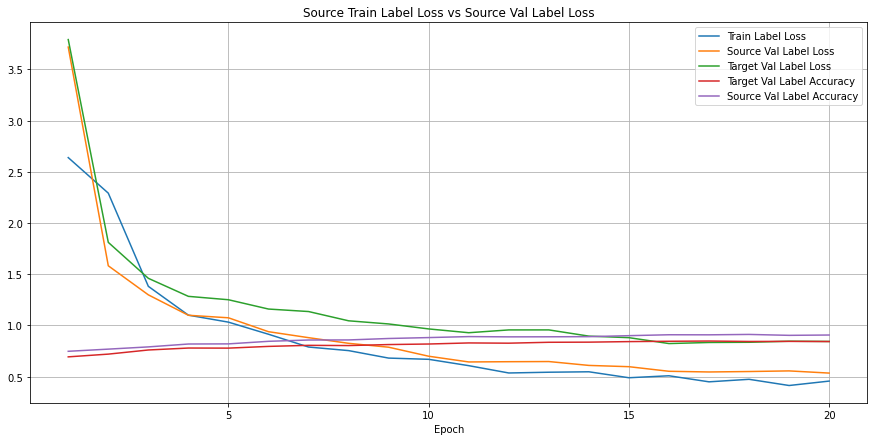

In [16]:
ax = get_loss_curve(experiment)
plt.show()

<AxesSubplot:title={'center':'Results'}>

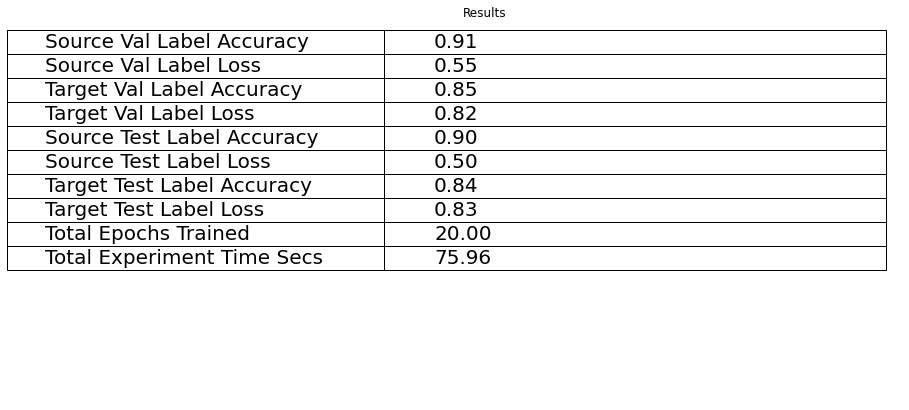

In [17]:
get_results_table(experiment)

<AxesSubplot:title={'center':'Per Domain Validation Accuracy'}, xlabel='domain'>

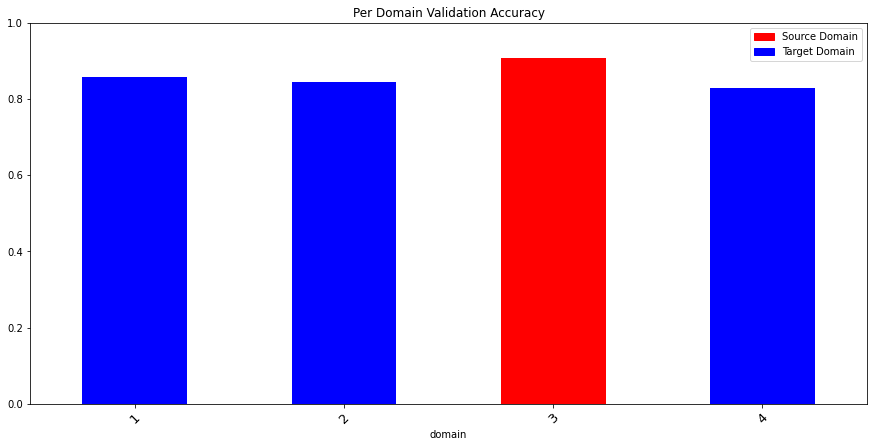

In [18]:
get_domain_accuracies(experiment)

In [19]:
print("Source Test Label Accuracy:", experiment["results"]["source_test_label_accuracy"], "Target Test Label Accuracy:", experiment["results"]["target_test_label_accuracy"])
print("Source Val Label Accuracy:", experiment["results"]["source_val_label_accuracy"], "Target Val Label Accuracy:", experiment["results"]["target_val_label_accuracy"])

Source Test Label Accuracy: 0.9038461538461539 Target Test Label Accuracy: 0.8371794871794872
Source Val Label Accuracy: 0.908974358974359 Target Val Label Accuracy: 0.8452991452991453


In [20]:
json.dumps(experiment)

'{"experiment_name": "baseline_ptn_32bit_wisig", "parameters": {"experiment_name": "baseline_ptn_32bit_wisig", "lr": 0.001, "device": "cuda", "seed": 1337, "dataset_seed": 1337, "labels_source": ["1-10", "1-12", "1-14", "1-16", "1-18", "1-19", "1-8", "10-11", "10-17", "10-4", "10-7", "11-1", "11-10", "11-19", "11-20", "11-4", "11-7", "12-19", "12-20", "12-7", "13-14", "13-18", "13-19", "13-20", "13-3", "13-7", "14-10", "14-11", "14-12", "14-13", "14-14", "14-19", "14-20", "14-7", "14-8", "14-9", "15-1", "15-19", "15-6", "16-1", "16-16", "16-19", "16-20", "17-10", "17-11", "18-1", "18-10", "18-11", "18-12", "18-13", "18-14", "18-15", "18-16", "18-17", "18-19", "18-2", "18-20", "18-4", "18-5", "18-7", "18-8", "18-9", "19-1", "19-10", "19-11", "19-12", "19-13", "19-14", "19-15", "19-19", "19-2", "19-20", "19-3", "19-4", "19-6", "19-7", "19-8", "19-9", "2-1", "2-13", "2-15", "2-3", "2-4", "2-5", "2-6", "2-7", "2-8", "20-1", "20-12", "20-14", "20-15", "20-16", "20-18", "20-19", "20-20", "20